In [100]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import Utils.iris_utils
import Utils.Gridding
from Utils.nc_processing import *
from Utils.analysis import * 
#from Utils.plotting import *
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
import scipy
#sns.set()

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    

def make_df(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))
    df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
    return df

def get_baseline(df, t_bnds=[1850, 1900], monthly=False):
    df_hist = df[df['Experiment']=='historical']
    df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]
    df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])
    if monthly:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds', 'Month']).mean().reset_index().rename(columns=baseline_name_changes)
    else:
        df_hist = df_hist.groupby(['Model', 'base_t_bnds']).mean().reset_index().rename(columns=baseline_name_changes)
    df_hist = df_hist.drop(columns=['year'])
    return df_hist

def wmean(df, values, weights):
    return sum(df[weights]*df[values])/df[weights].sum()

def preprocess_hadcrut_z(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['Year'].between(preind_period[0], preind_period[1])]
    offset = df_pre_ind['Anomaly (deg C)'].mean()
    df_out = df[['Year', 'Anomaly (deg C)']]
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'] - offset
    df_out['Anomaly (deg C)'] = df_out['Anomaly (deg C)'].rolling(window, center=True).mean()
    return df_out

def preprocess_hadcrut(df, window, preind_period=[1850,1900]):
    """ hadcrut analysis annual means tas data is donwloaded as anomaly relative to the period 
        1961-1990, (see description here: https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/download.html)
        we preprocess by re-baselining this to be anomaly relative to our preindustrial period, 1850-1900""
    
    returns df with tas relative to pre-industrial mean """
    #df.rename(columns={'Time':'Year'}, inplace=True)
    df_pre_ind = df[df['year'].between(preind_period[0], preind_period[1])]
    offset_w = df_pre_ind['world_tas'].mean()
    offset_na = df_pre_ind['no_arctic_tas'].mean()
    df_out = df.copy()
    df_out['world_tas'] = df_out['world_tas'] - offset_w
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'] - offset_na
    df_out['world_tas'] = df_out['world_tas'].rolling(window, center=True).mean()
    df_out['no_arctic_tas'] = df_out['no_arctic_tas'].rolling(window, center=True).mean()
    return df_out

In [103]:
### set up and read in temp data

## models
baseline_name_changes = {'no_arctic_tas':'no_arctic_base_tas',
                         'world_tas':'world_base_tas',
                        }
window=15
temp_thresh = 2

in_folder_tas = 'int_outputs/temperature_v2/'
#exp='ssp370'
exp='ssp245'
#exp='ssp126'
tas_df = make_df(in_folder_tas)
tas_df = tas_df[tas_df['Experiment'].isin(['historical', exp])]
#tas_df.set_index('year',inplace=True)
print(tas_df['Model'].unique())

## observations
#Hadcrut_file = 'Inputs/HadCRUT5/Downloaded_29_12_22/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv'
Hadcrut_file = 'int_outputs/temperature_hadcrut/hadcrut5_tas.csv'
Hadcrut_df = preprocess_hadcrut(pd.read_csv(Hadcrut_file), window=window)



['TaiESM1' 'AWI-CM-1-1-MR' 'MCM-UA-1-0' 'CIESM' 'SAM0-UNICON' 'NESM3'
 'GFDL-ESM4' 'GFDL-CM4' 'UKESM1-0-LL' 'KACE-1-0-G' 'NorESM2-MM'
 'NorESM2-LM' 'NorCPM1' 'CESM2-WACCM-FV2' 'CESM2-WACCM' 'CESM2-FV2'
 'CESM2' 'GISS-E2-2-H' 'GISS-E2-1-H' 'GISS-E2-1-G-CC' 'GISS-E2-1-G'
 'MRI-ESM2-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'UKESM1-1-LL'
 'HadGEM3-GC31-MM' 'HadGEM3-GC31-LL' 'MIROC6' 'MIROC-ES2L' 'MIROC-ES2H'
 'KIOST-ESM' 'IPSL-CM6A-LR-INCA' 'IPSL-CM6A-LR' 'IPSL-CM5A2-INCA'
 'INM-CM5-0' 'INM-CM4-8' 'MPI-ESM-1-2-HAM' 'FIO-ESM-2-0'
 'EC-Earth3-Veg-LR' 'BCC-CSM2-MR' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'FGOALS-f3-L'
 'FGOALS-g3' 'IITM-ESM' 'CanESM5' 'CanESM5-CanOE' 'CMCC-CM2-SR5'
 'CMCC-ESM2' 'CNRM-CM6-1' 'CNRM-CM6-1-HR' 'CNRM-ESM2-1' 'ACCESS-ESM1-5'
 'ACCESS-CM2' 'E3SM-1-1' 'EC-Earth3' 'EC-Earth3-CC' 'EC-Earth3-Veg']


In [105]:
### initial processing, add baseline temp to each model, 
### only keep those models with a historic scenario available

tas_df = tas_df.groupby(['year', 'Experiment', 'Model']).mean().reset_index() 

base_tas_df = get_baseline(tas_df, [1850, 1900])
tas_df = pd.merge(tas_df, base_tas_df, how='left', on=['Model'])
tas_df['no_arctic_tas_anom'] = tas_df['no_arctic_tas'] - tas_df['no_arctic_base_tas']
tas_df['world_tas_anom'] = tas_df['world_tas'] - tas_df['world_base_tas']

models = tas_df[tas_df['Experiment']==exp]['Model'].unique()
tas_df = tas_df[tas_df['Model'].isin(models)]
tas_df = tas_df.dropna()

models = tas_df['Model'].unique()
models

/tmp/ipykernel_560/2799509366.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_hist = df_hist[df_hist['year'] > t_bnds[0]][df_hist['year'] < t_bnds[1]]
/tmp/ipykernel_560/2799509366.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hist['base_t_bnds'] = str(t_bnds[0]) + '-' + str(t_bnds[1])


array(['AWI-CM-1-1-MR', 'CESM2', 'CESM2-WACCM', 'CIESM',
       'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4',
       'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'INM-CM4-8', 'INM-CM5-0',
       'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1',
       'UKESM1-0-LL'], dtype=object)

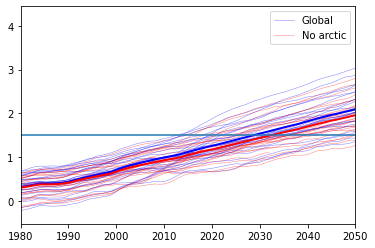

In [106]:
### initial basic plot, no correction to force realistic present temps

for model in models:
    df = tas_df[tas_df['Model']==model]
    plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=0.5, linewidth=0.5, label='Global')
    plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=0.5, linewidth=0.5, label='No arctic')

df = tas_df.groupby(['year']).mean().reset_index() 
plt.plot(df['year'], df['world_tas_anom'].rolling(window, center=True).mean(), c='b', alpha=1, linewidth=2, label='Global')
plt.plot(df['year'], df['no_arctic_tas_anom'].rolling(window, center=True).mean(), c='r', alpha=1, linewidth=2, label='No arctic')

legend_without_duplicate_labels(plt.gca())
plt.xlim(1980,2050)
plt.axhline(1.5)
plt.savefig('Figures/tas_anom_global_and_no_arctic.png', dpi=300)


In [107]:


#df= tas_df[tas_df['Experiment'] == exp]
df = tas_df.drop(columns=['Experiment'])
models = df['Model'].unique()
Model = []
No_arctic = []
World = []

for m in models:
    m_df = df[df['Model']==m]
    no_arctic_crossing_year = np.interp(temp_thresh, m_df['no_arctic_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    world_crossing_year = np.interp(temp_thresh, m_df['world_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
    Model.append(m)
    No_arctic.append(np.round(no_arctic_crossing_year,3))
    World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']
print('mean gap: ' + str(np.round(out_df['gap'].mean(), 2)))
out_df.to_csv('Outputs/crossing_years.csv')
out_df

mean gap: 6.38


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2044.513,2040.018,4.495
1,CESM2,2053.621,2046.355,7.266
2,CESM2-WACCM,2044.996,2041.236,3.760
3,CIESM,2028.176,2026.561,1.615
4,EC-Earth3-Veg-LR,2054.834,2048.728,6.106
5,FIO-ESM-2-0,2037.186,2032.090,5.096
6,GFDL-CM4,2054.548,2049.268,5.280
7,GFDL-ESM4,2077.837,2074.174,3.663
8,GISS-E2-1-G,2088.807,2084.723,4.084
9,HadGEM3-GC31-LL,2041.392,2037.479,3.913


In [90]:
float(Hadcrut_df.dropna().tail(1)['Anomaly (deg C)'])

1.1620030507254904

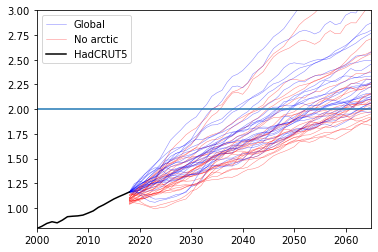

In [95]:
""" repeat, this time scaling temps to current observed warming """

warming_obs = float(Hadcrut_df.dropna().tail(1)['Anomaly (deg C)'])
obs_year = int(Hadcrut_df.dropna().tail(1)['Year'])

Model = []
No_arctic = []
World = []
df = tas_df
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for m in models:
        m_df = df[df['Model']==m]
        m_df['rolling_world_anom'] = m_df['world_tas_anom'].rolling(window, center=True).mean()
        ratio = (m_df[m_df['year']==obs_year]['rolling_world_anom']/warming_obs).values[0]
        m_df['adjusted_world_tas_anom']= (m_df['world_tas_anom']/ratio).rolling(window, center=True).mean()
        m_df['adjusted_no_arctic_tas_anom']= (m_df['no_arctic_tas_anom']/ratio).rolling(window, center=True).mean()
        m_df = m_df[m_df['year'] >= obs_year]
        plt.plot(m_df['year'], m_df['adjusted_world_tas_anom'], c='b', alpha=0.5, linewidth=0.5, label='Global')
        plt.plot(m_df['year'], m_df['adjusted_no_arctic_tas_anom'], c='r', alpha=0.5, linewidth=0.5, label='No arctic')

        #also calc crossings again
        no_arctic_crossing_year = np.interp(temp_thresh, m_df['adjusted_no_arctic_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
        world_crossing_year = np.interp(temp_thresh, m_df['adjusted_world_tas_anom'].rolling(window, center=True).mean(), m_df['year'])
        Model.append(m)
        No_arctic.append(np.round(no_arctic_crossing_year,3))
        World.append(np.round(world_crossing_year,3))

out_df = pd.DataFrame({'Model':Model,
                       'No_arctic_crossing_year':No_arctic,
                       'World_crossing_year':World})
out_df['gap'] = out_df['No_arctic_crossing_year'] - out_df['World_crossing_year']

#mm_mean_df = out_df.groupby()

## add observations:
plt.plot(Hadcrut_df['Year'], Hadcrut_df['Anomaly (deg C)'], c='black', label='HadCRUT5')
    
legend_without_duplicate_labels(plt.gca())
plt.xlim(2000,2065)
plt.ylim(0.8, 3)
plt.axhline(temp_thresh)


plt.savefig('Figures/adjusted_tas_anom_global_and_no_arctic.png', dpi=300)

2018

In [92]:
print('mean gap: ' + str(np.round(out_df['gap'].mean(), 2)))
out_df.to_csv('Outputs/crossing_years_adjusted.csv')
out_df

mean gap: 5.97


,Model,No_arctic_crossing_year,World_crossing_year,gap
0,AWI-CM-1-1-MR,2064.193,2055.113,9.080
1,CESM2,2042.585,2039.180,3.405
2,CESM2-WACCM,2050.679,2046.664,4.015
3,CIESM,2058.139,2054.791,3.348
4,EC-Earth3-Veg-LR,2068.697,2062.523,6.174
5,FIO-ESM-2-0,2063.858,2055.510,8.348
6,GFDL-CM4,2047.408,2043.708,3.700
7,GFDL-ESM4,2063.260,2057.251,6.009
8,GISS-E2-1-G,2035.567,2033.992,1.575
9,HadGEM3-GC31-LL,2044.801,2041.448,3.353
